#  Sentiment Analysis on Reddit Discussions of Unions: Exploring Supervised and Unsupervised Approaches for Labor Topics
## Data 622 Final Project

### AJ Strauman-Scott
#### December 20, 2024


# Introduction
This project uses machine learning techniques to investigate sentiment trends about labor unions and labor strikes among Reddit users within the last calendar year. By focusing on posts and comments from a diverse set of subreddits, this project seeks to capture a wide spectrum of political opinions and explore the dynamics of online discourse on these critical labor topics. To accomplish this, this project employs both a custom-trained Naive Bayes model and an industry-standard RoBERTa transformer model - both trained on manually labelled dat - and compares the results. The comparative analysis of these models serves as a foundation for more advanced explorations, including deep clustering of the larger dataset.

This study's primary objective is to identify and understand sentiment trends among Reddit users on modern labor issues, while assessing the relative performance of simpler, interpretable models against sophisticated transformer-based architectures.This analysis offers insights into the role of unions and strikes in contemporary public opinion as well as evaluates the effectiveness of different machine learning approaches in processing and analyzing large, noisy datasets for sentiment analysis.
# Data Source
The data utilized in this study were scraped from Reddit for the purposes of this study. Reddit is a forum-based social media application, a platform known for its diverse user base and active discussions on various topics, including labor and politics. To ensure a comprehensive and balanced representation of opinions on labor-related issues, the data collection focused on subreddits that reflect a wide range of political ideologies and interest groups. These subreddits included broad political communities such as "Conservative," "Liberal," "Libertarian," and "Progressive", as well as topic-specific communities like "antiwork," "Truckers," and "BlueCollarWomen." 

The selection of subreddits was designed to mitigate ideological bias by incorporating both general political discussions and specialized labor-oriented communities. Posts and comments were scraped using a keyword-based approach, with a focus on those containing terms such as "union" or "strike." The inclusion of both posts and comments ensures that the dataset captures both original content and community reactions, reflecting a multi-dimensional view of labor discourse.

After applying these criteria, a total of 14,316 observations were collected, encompassing a mix of text-based posts and comment threads. The resulting dataset serves as a robust foundation for analyzing public sentiment and discourse patterns related to labor and worker issues on Reddit.

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import joblib
import spacy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.naive_bayes import ComplementNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_recall_fscore_support,
    silhouette_score,
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.utils.class_weight import compute_class_weight
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from spacy.lang.en import STOP_WORDS
from datasets import Dataset
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from transformers import (
    EarlyStoppingCallback,
    RobertaTokenizer,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    RobertaConfig,
)

During the initial review of the data, some texts referred to unrelated topics, despite filtering during the scraping process. Irrelevant topics such as military strikes or the Soviet Union were removed using additional filtering keywords "Israel," "drone," and "Soviet." After preprocessing and filtering, the dataset represents a rich corpus of user-generated content spanning various socioeconomic and ideological contexts.

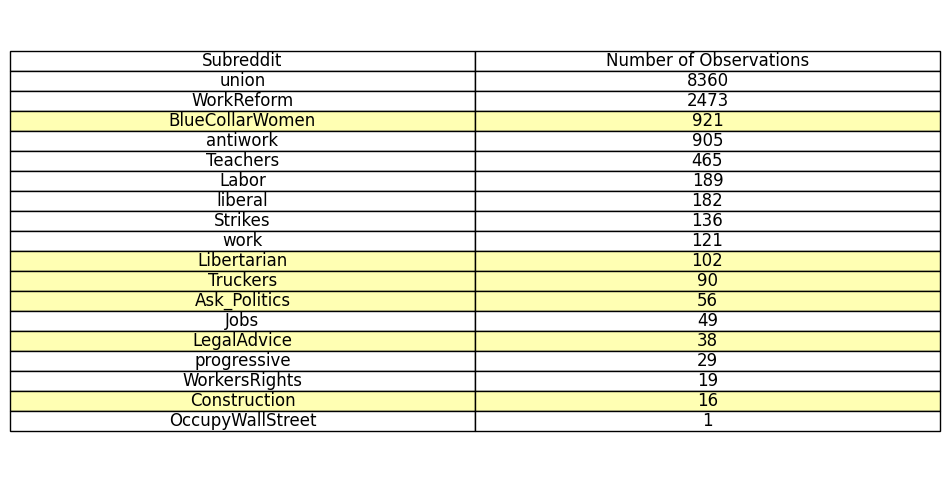

In [ ]:
# LOAD DATA
# labelled sample
pickle_folder = "./data/pickle"
pickle_path = os.path.join(pickle_folder, "reddit_labelled-sample.pkl")
reddit_sample = joblib.load(pickle_path)

# full dataset
pickle_path = os.path.join(pickle_folder, "reddit.pkl")
reddit_full = joblib.load(pickle_path)

# filter words
filter_words = ["israel", "drone", "soviet"]
def contains_filter_words(text):
    return any(word in text.lower() for word in filter_words)
reddit_sample = reddit_sample[~reddit_sample["text"]
                              .apply(contains_filter_words)].drop_duplicates()
reddit_full = reddit_full[~reddit_full["text"]
                          .apply(contains_filter_words)].drop_duplicates()

# subreddit counts
subreddit_counts = reddit_full["subreddit"].value_counts()

subreddit_counts_df = subreddit_counts.reset_index()
subreddit_counts_df.columns = ["Subreddit", "Number of Observations"]

highlighted_subreddits = [
    "BlueCollarWomen",
    "Libertarian",
    "Truckers",
    "Construction",
    "LegalAdvice",
    "Ask_Politics",
    "jobs",
]

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("tight")
ax.axis("off")

table = ax.table(
    cellText=subreddit_counts_df.values,
    colLabels=subreddit_counts_df.columns,
    cellLoc="center",
    loc="center",
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

for i, row in enumerate(subreddit_counts_df["Subreddit"]):
    if row in highlighted_subreddits:
        for j in range(len(subreddit_counts_df.columns)):
            table[(i + 1, j)].set_facecolor(
                "#ffffb3"
            ) 

plt.show()

The table above provides an overview of the distribution of observations across subreddits. The r/union subreddit dominates the dataset, contributing a significant portion of the total entries (8,360 observations). Given its explicit focus on unionization and labor rights, this project anticipates this content will be heavily biased prounion. This inherent bias highlights the need for a balanced analysis, as r/union represents a community that actively supports unionization efforts rather than offering a neutral or opposing perspective.

Other notable contributions come from subreddits such as r/WorkReform (2,473 observations), r/BlueCollarWomen (921 observations), and r/antiwork (905 observations). These subreddits also lean heavily toward pro-labor discourse, with discussions often centered on worker advocacy, workplace equity, and unionization as solutions to systemic labor issues.

Highlighted in the table are several conservative-leaning subreddits, including r/Libertarian (102 observations), r/Truckers (90 observations), and r/Construction (16 observations). These subreddits collectively contribute far fewer observations compared to more labor-focused or politically progressive communities. This disparity underscores a critical observation: discussions about unions and strikes tend to be less prominent in conservative-leaning spaces. The limited representation may reflect ideological skepticism toward collective labor actions or unionization, often associated with conservative or libertarian viewpoints.

Notably, there are no active anti-union subreddits to provide a counterbalance to pro-union perspectives. This absence, combined with the dominance of labor-friendly subreddits such as r/union, r/WorkReform, and r/antiwork, introduces an inherent bias in the dataset. While these communities enrich the corpus with a wealth of labor-oriented discussions, the perspectives of individuals or groups opposed to unions are underrepresented. This limitation highlights the importance of interpreting the findings within the context of the dataset’s composition.
# Methodology
To evaluate sentiment classification performance, this study uses a comparative supervised learning framework that included both traditional and transformer-based models, alongside unsupervised clustering methods to uncover latent structures in the data. 

A randomly selected subset of 1,600 observations was manually labeled to provide the foundation for initial model training and evaluation. This labeled dataset trained a Naive Bayes classifier, and a roBERTa transformer model.

The Naive Bayes model trained on an oversampled version of the labeled dataset to address class imbalances. Text data was preprocessed using TF-IDF vectorization, and hyperparameter tuning was performed to optimize its performance. The oversampling ensured that the model was trained on a balanced dataset, mitigating potential biases caused by underrepresented classes.

A RoBERTa transformer model was fine-tuned using the same oversampled dataset. This approach allowed for a direct comparison with the Naive Bayes classifier. 

Each model was evaluated using consistent training and testing splits to ensure a fair comparison of performance metrics. The outputs of the Naive Bayes model and the best-performing RoBERTa model were subsequently used to label the entire dataset.

In addition to supervised classification, this project employed the embeddings from the best-performing fine-tuned RoBERTa model as input for unsupervised clustering techniques, including a Deep Clustering with Semantic Contrastive Learning (DCSC) model. By applying DCSC, this study delves into the nuanced groupings and relationships present in the discourse surrounding labor issues. Specifically, DCSC enables the identification of clusters that may represent distinct communities, ideological subgroups, or thematic areas of focus, such as discussions around wages, unionization efforts, strikes, or worker rights. This clustering approach helps uncover hidden patterns in user-generated content that might not be immediately apparent through supervised classification alone. 

In [3]:
# INITALIZE OBJECTS
nlp = spacy.load("en_core_web_sm")
vectorizer = TfidfVectorizer(
    ngram_range=(1, 3), 
    sublinear_tf=True, 
    stop_words="english"
)
encoder = LabelEncoder()
analyzer = SentimentIntensityAnalyzer()
cnb = ComplementNB()
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
stop_words = set(STOP_WORDS)
lemmatizer = WordNetLemmatizer()
analyzer = SentimentIntensityAnalyzer()
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
ros = RandomOverSampler(random_state=42)

In [4]:
# PREPROCESS TEXT
def preprocess_text(text):
    text =  text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in STOP_WORDS]
    return " ".join(tokens)


# Preprocess and augment text
reddit_sample["text_processed"] = (reddit_sample["text"].apply(preprocess_text))
reddit_full["text_processed"] = (reddit_full["text"].apply(preprocess_text))

# Supervised Learning
The preprocessing pipeline begins by cleaning the Reddit dataset with a custom `preprocess_text` function. Each piece of text was tokenized, lowercased, and filtered to remove non-alphabetic tokens and common stopwords using SpaCy's `STOP_WORDS`. The text was further lemmatized, reducing words to their base forms to ensure that different inflections of the same word (e.g., "union" and "unions") were treated as a single feature. This preprocessed text is used for both the Naive Bayes and RoBERTa models. 

The dataset is then split into training and testing sets using the `train_test_split` function with stratified sampling to preserve class distribution. Given the class imbalance in the sample dataset dataset (only about 20% of the sample were negative sentiments), a `Random Oversampling` (ROS) strategy was applied to the training data. This technique balanced the training dataset by oversampling the minority classes, ensuring equal representation of all sentiment labels during training. Both models are trained on balanced data while being tested on the same stratified testing set for a fair evaluation.

In [5]:
# SPLIT DATA
X = reddit_sample["text_processed"]
y = reddit_sample["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Oversample
X_train_balanced, y_train_balanced = ros.fit_resample(X_train.to_frame(), y_train)
X_train_balanced = X_train_balanced.squeeze()
print("Before Oversampling:", Counter(y_train))
print("After Oversampling:", Counter(y_train_balanced))

Before Oversampling: Counter({'positive': 507, 'neutral': 485, 'negative': 213})
After Oversampling: Counter({'neutral': 507, 'positive': 507, 'negative': 507})


### TRAIN NAIVE BAYES
The design and implementation of the Naive Bayes classifier in this study was carefully tailored to the specific characteristics of the dataset and the requirements of text classification.

For feature extraction, the TF-IDF (Term Frequency-Inverse Document Frequency) method was employed using a custom-configured vectorizer. This transformation converted the processed text into a numerical format suitable for machine learning by encoding the relative importance of words within the corpus. The vectorizer was configured to capture uni-, bi-, and tri-grams, enabling the model to consider both individual words and short phrases.

`ComplementNB`, a variant of the Naive Bayes algorithm, was chosen as the primary algorithm for its robustness in handling imbalanced datasets. `ComplementNB` mitigates the bias that might arise from oversampling by focusing on rare terms that are most likely to be misclassified.

To optimize the model's performance, hyperparameter tuning was conducted using a grid search over a range of smoothing parameters (`alpha`). This parameter controls how the model handles zero probabilities for unseen words, which is crucial for text data with many sparse features. A 10-fold cross-validation approach was used to identify the best-performing configuration, ensuring that the model generalized well across different subsets of the training data. The final model was then trained on the balanced training set using the best hyperparameters identified through the grid search. Key metrics, including weighted F1-score as a robust metric against class imbalance, were used to assess the model's performance comprehensively.

Finally, the trained Naive Bayes model was applied to the entire dataset to assign sentiment labels to all posts and comments, extending its utility beyond the training and testing sets.

In [ ]:
# NAIVE BAYES
# vectorize
X_train_vec = vectorizer.fit_transform(X_train_balanced)
X_test_vec = vectorizer.transform(X_test)

# encode
y_train_encoded = encoder.fit_transform(y_train_balanced)
y_test_encoded = encoder.transform(y_test)

# param grid
param_grid = {"alpha": [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}
grid_search = GridSearchCV(
    estimator=cnb,
    param_grid=param_grid,
    scoring="f1_weighted",
    cv=10,
    n_jobs=-1,
    verbose=2,
)
grid_search.fit(X_train_vec, y_train_encoded)
print(f"Best parameter: {grid_search.best_params_}")

# best model
nb_model = grid_search.best_estimator_

# predict
y_pred = nb_model.predict(X_test_vec)

# decode
nb_model_pred = encoder.inverse_transform(y_pred)
y_test_decoded = encoder.inverse_transform(y_test_encoded)


# predict for full dataset)
reddit_full["label_nb"] = nb_model.predict(
    vectorizer.transform(reddit_full["text_processed"])
)
reddit_full["label_nb"] = encoder.inverse_transform(reddit_full["label_nb"])

### TRAIN ROBERTA MODEL

The implementation of the RoBERTa-based sentiment classification model was designed to use the strengths of transformer-based architectures while addressing the inherent challenges of the dataset. The model utilized the pre-trained `roberta-base` transformer from Hugging Face, fine-tuned on the labeled dataset to classify sentiments into distinct categories.

The preprocessing pipeline ensured compatibility with the RoBERTa transformer architecture. Raw text data was tokenized using the Hugging Face `RobertaTokenizer`, which splits text into subword units and maps them to RoBERTa's vocabulary. To streamline the input, each text was padded or truncated to a uniform maximum sequence length of 128 tokens. 

Class imbalance in the dataset was addressed using the same Random Oversampling (ROS) technique as in the Naive Bayes model. By replicating minority class samples, ROS ensured that the model received balanced exposure to all classes during training, thereby reducing the risk of bias toward the majority class without removing any samples from the training data. While oversampling introduces the potential risk of overfitting to duplicated samples, it also allows the model to predict minority class sentiments more effectively.

The model was fine-tuned using the Hugging Face `Trainer` API. Optimization techniques included a learning rate scheduler, gradient clipping to stabilize training, and an early stopping mechanism to prevent overfitting. The learning rate was set to 5e-6, and a batch size of 8 was used for efficient gradient updates. The model was allowed up to 20 epochs of training but was configured to stop early if performance did not improve for three consecutive evaluation steps. The model’s performance was evaluated using accuracy, precision, recall, and the weighted F1-score to capture the nuanced challenges of classifying imbalanced sentiment data.

In [ ]:
# TRAIN ROBERTA

# initialize 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# tokenize
def tokenize_data(texts, tokenizer, max_length=128):
    return tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt",
    )

train_encodings = tokenize_data(X_train_balanced, tokenizer)
test_encodings = tokenize_data(X_test, tokenizer)

train_dataset = Dataset.from_dict(
    {
        "input_ids": train_encodings["input_ids"],
        "attention_mask": train_encodings["attention_mask"],
        "labels": y_train_encoded,
    }
)
test_dataset = Dataset.from_dict(
    {
        "input_ids": test_encodings["input_ids"],
        "attention_mask": test_encodings["attention_mask"],
        "labels": y_test_encoded,
    }
)

# metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=0
    )
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


# roberta model
roberta_model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(encoder.classes_),
).to(device)

training_args = TrainingArguments(
    output_dir="./models/roberta/results",
    report_to=["none"],
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-6,
    warmup_steps=150,
    lr_scheduler_type="linear",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.02,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    gradient_accumulation_steps=8,
    max_grad_norm=1.0,
)

# trainer
trainer = Trainer(
    model=roberta_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# train
trainer.train()

# save and predict
trainer.save_model("./models/roberta/final_model")
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
decoded_preds = encoder.inverse_transform(preds)
decoded_labels = encoder.inverse_transform(y_test_encoded)

In [ ]:
# LABEL WITH ROBERTA
def predict_with_roberta(text):
    roberta_model.eval()
    inputs = tokenizer(
        text, padding=True, truncation=True, max_length=512, return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        outputs = roberta_model(**inputs)
        logits = outputs["logits"]
        predicted_label = torch.argmax(logits, axis=1).item()
    decoded_label = encoder.inverse_transform([predicted_label])[0]
    return decoded_label

# predict the full dataset
reddit_full["label_rob"] = reddit_full["text"].apply(predict_with_roberta)

output_csv_path = "./data/master/reddit_labelled_final.csv"
output_pkl_path = "./data/pickle/reddit_labelled_final.pkl"
reddit_full.to_csv(output_csv_path, index=False)
joblib.dump(reddit_full, output_pkl_path)

# Unsupervised Learning
Now the fine-tuned RoBERTa transformer trains a custom Deep Clustering by Semantic Contrastive Learning (DCSC) model for advanced clustering of Reddit data for sentiment analysis. 

The Deep Clustering with Semantic Contrastive Learning (DCSC) model was designed to uncover latent structures and groupings within the dataset by combining supervised embeddings with unsupervised clustering techniques. The intention is to utilize RoBERTa’s language understanding capabilities to generate high-quality embeddings, which are subsequently refined and used for clustering via contrastive and clustering losses. This process involves multiple steps, beginning with data preprocessing, followed by initializing the clustering model, and culminating in a training process that alternates between embedding updates and clustering refinement.

The `DCSCModel` class builds upon the RoBERTa encoder by adding two additional components: a projection head and a clustering head. The RoBERTa encoder generates dense, contextual embeddings for the input text, capturing the semantic nuances of each sentence or post. These embeddings are then passed through a projection head, which reduces their dimensionality using a multi-layer perceptron with a hidden ReLU activation. Finally, a clustering head projects the reduced embeddings into a smaller space corresponding to the predefined number of clusters (10 in this study). 

ReLU introduces non-linearity into the model, which is critical for learning complex patterns and interactions within the data. Unlike sigmoid or tanh activations, ReLU is computationally efficient, as it involves a simple threshold operation that sets negative values to zero. ReLU also mitigates the vanishing gradient problem, enabling stable and effective backpropagation during training. By zeroing out negative values, it also introduces sparsity in the output, promoting feature selection and improving the model's generalization capacity. A dropout rate of 0.5 was applied in the projection head to prevent overfitting. This choice ensures that the model generalizes well to unseen data while maintaining the quality of learned embeddings.

The DCSC model employs two complementary loss functions: a contrastive loss and a clustering loss. Contrastive loss encourages the model to learn embeddings that are distinct from one another, normalizing them to ensure that similar inputs cluster together while dissimilar inputs remain separated. This is achieved by computing a similarity matrix between embeddings and optimizing their alignment with self-generated labels. The temperature parameter in the contrastive loss function was set to 0.5. By dividing the cosine similarity between embeddings by the temperature, the model controls how strongly it distinguishes between positive and negative samples in the contrastive loss. The choice of 0.5 balances the need for strong clustering with stability during training. 

Clustering loss, on the other hand, operates on the output of the clustering head. It minimizes the Kullback-Leibler (KL) divergence between the predicted cluster distribution and a target distribution. The target distribution is updated iteratively based on the squared probability of each cluster assignment, amplifying the weights of confident predictions while refining the clustering process. The target distribution update, based on soft cluster assignments, was iteratively refined during training.  These two loss components are weighted and combined during training. The lambda clustering parameter, set to 0.5, determines the relative importance of the clustering loss (KL divergence) compared to the contrastive loss. The value of 0.5 was chosen to give equal weight to both objectives.

The model training loop iteratively fine-tunes the clustering process over a series of 10 epochs. For each batch of data, embeddings are computed using the RoBERTa encoder and the projection head, while cluster logits are generated by the clustering head. Both the contrastive and clustering losses are calculated, and their gradients are backpropagated to update model parameters. To ensure training stability, gradient clipping is applied, limiting the maximum gradient norm.

In addition to supervised optimization, unsupervised K-Means clustering is performed at the end of each epoch. The embeddings generated by the model are clustered into 10 groups, and the results are used to update the target distribution for the clustering loss in the subsequent epoch. This iterative approach refines the cluster assignments over time, aligning them more closely with the data's underlying structure. The silhouette score, a measure of cluster cohesion and separation, is computed after each epoch to evaluate the quality of the clustering.

The decision to use ten clusters in the DCSC model was based on balancing interpretability and the diversity of underlying patterns in the dataset. With a broad array of user-generated content sourced from Reddit, including discussions on labor, unions, strikes, and related socioeconomic issues, the data likely spans a wide range of themes and subtopics. Ten clusters provide enough granularity to capture meaningful distinctions between these themes while remaining manageable for interpretation and analysis.


In [ ]:
# TRAIN DCSC MODEL
class DCSCModel(nn.Module):
    def __init__(self, roberta_model, embedding_dim=768, num_clusters=10):
        super(DCSCModel, self).__init__()
        self.encoder = roberta_model
        self.projection_head = nn.Sequential(
            nn.Linear(embedding_dim, 256), nn.ReLU(), nn.Linear(256, 128)
        )
        self.clustering_head = nn.Linear(128, num_clusters)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            encoded = self.encoder.roberta(
                input_ids=input_ids, attention_mask=attention_mask
            )
        embeddings = self.projection_head(encoded.last_hidden_state[:, 0, :])
        cluster_logits = self.clustering_head(embeddings)
        return embeddings, cluster_logits


# Loss Functions
def contrastive_loss(embeddings, temperature=0.5):
    # NAs with 0
    embeddings = torch.nan_to_num(embeddings, nan=0.0)
    embeddings_np = embeddings.detach().cpu().numpy()

    # normalize
    embeddings_np = normalize(embeddings_np + 1e-10, axis=1)
    embeddings_normalized = torch.tensor(embeddings_np, dtype=torch.float32).to(
        embeddings.device
    )
    # similarity matrix
    similarity_matrix = (
        torch.matmul(embeddings_normalized, embeddings_normalized.T) / temperature
    )
    labels = torch.arange(similarity_matrix.size(0)).to(similarity_matrix.device)
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(similarity_matrix, labels)
    return loss


def clustering_loss(cluster_logits, target_distribution):
    pred_distribution = torch.clamp(
        torch.softmax(cluster_logits, dim=1), 
        min=1e-10, 
        max=1 - 1e-10
    )
    kl_div = torch.sum(
        target_distribution
        * torch.log(target_distribution / pred_distribution + 1e-10),
        dim=1,
    )
    return kl_div.mean()


# distribution update
def update_target_distribution(cluster_logits):
    pred_distribution = torch.softmax(cluster_logits, dim=1).detach()
    weight = pred_distribution**2 / torch.sum(pred_distribution, dim=0)
    return (weight.T / torch.sum(weight, dim=1)).T


# initialize
num_clusters = 10
config = RobertaConfig.from_pretrained("./models/roberta/final_model")
pretrained_roberta = RobertaForSequenceClassification.from_pretrained(
    "./models/roberta/final_model",
    config=config
)

# dcsc model
dcsc_model = DCSCModel(pretrained_roberta, num_clusters=num_clusters).to(device)
optimizer = optim.Adam(dcsc_model.parameters(), lr=3e-4)

train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=data_collator
)

# training loop
epochs = 10
temperature = 0.5
lambda_clustering = 0.5

for epoch in range(epochs):
    dcsc_model.train()
    total_loss = 0
    embeddings_list = []
    cluster_logits_list = []

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        optimizer.zero_grad()

        # forward pass
        embeddings, cluster_logits = dcsc_model(input_ids, attention_mask)

        # store embeddings and logits
        embeddings_list.append(embeddings.detach().cpu())
        cluster_logits_list.append(cluster_logits.detach().cpu())

        # compute loss
        c_loss = contrastive_loss(embeddings, temperature)
        t_distribution = update_target_distribution(cluster_logits)
        k_loss = clustering_loss(cluster_logits, t_distribution)

        # combine losses
        loss = c_loss + lambda_clustering * k_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(dcsc_model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

    # kmeans clustering
    all_embeddings = torch.cat(embeddings_list).numpy()
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(all_embeddings)
    cluster_assignments = kmeans.labels_

    # update distribution
    target_distribution = update_target_distribution(
        torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)
    )

    # silhouette
    silhouette_avg = silhouette_score(all_embeddings, cluster_assignments)
    print(f"Epoch {epoch+1}, Silhouette Score: {silhouette_avg:.4f}")

    # pca
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(all_embeddings)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=cluster_assignments,
        cmap="viridis",
        alpha=0.7,
    )
    plt.colorbar(scatter, label="Cluster")
    plt.title(f"Cluster Visualization at Epoch {epoch+1}")
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    plt.show()


torch.save(dcsc_model.state_dict(), "./models/DCSC/dcsc_model.pth")
np.save("./models/DCSC/cluster_assignments.npy", cluster_assignments)

The trained DCSC model is applied to the full Reddit dataset, just like the Naive Bayes and RoBERTa models have been. The Reddit dataset now includes predictions from the Naive Bayes model (`nb_label`) and the RoBERTa model (`rob_label`). Additionally, each observation in the dataset has been assigned to a cluster based on the embeddings generated by the DCSC model.

In [20]:
# CLUSTER WITH DCSC MODEL
dcsc_model.eval()

# tokenize
full_encodings = tokenizer(
    reddit_full["text_processed"].tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt",
)

full_dataset = Dataset.from_dict(
    {
        "input_ids": full_encodings["input_ids"],
        "attention_mask": full_encodings["attention_mask"],
    }
)
full_loader = DataLoader(
    full_dataset, batch_size=32, shuffle=False, collate_fn=data_collator
)

all_embeddings = []

with torch.no_grad():
    for batch in tqdm(full_loader, desc="Generating embeddings"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # forward pass
        embeddings, _ = dcsc_model(input_ids, attention_mask)
        all_embeddings.append(embeddings.cpu().numpy())

# combine embeddings
all_embeddings = np.vstack(all_embeddings)

# kmeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(all_embeddings)
full_cluster_assignments = kmeans.labels_

# save
reddit_full["cluster"] = full_cluster_assignments
reddit_full.to_csv("./data/master/reddit_with_clusters.csv", index=False)
output_pkl_path = "./data/pickle/reddit_with_clusters.pkl"
joblib.dump(reddit_full, output_pkl_path)

# Results
This section presents the performance and insights gained from the models applied to Reddit sentiment analysis. The evaluation focuses on the Naive Bayes and RoBERTa models, both trained on the oversampled dataset to address class imbalance. Key performance metrics such as accuracy, precision, recall, and F1-score are compared to assess the effectiveness of the models in sentiment classification. Additionally, the results of the Deep Clustering by Semantic Contrastive Learning (DCSC) model are analyzed to uncover meaningful clusters and topics within the data, providing a deeper understanding of Reddit users' discussions around unions and labor strikes. Visualizations and keyword analyses are included to contextualize the findings.

In [21]:
# Naive Bayes Test Set Accuracy
accuracy_nb = accuracy_score(y_test_decoded, nb_model_pred)
print(f"Naive Bayes Test Set Accuracy: {accuracy_nb}")
print("Naive Bays Classification Report:")
print(
    classification_report(
        y_test_decoded,
        nb_model_pred,
        target_names=encoder.classes_,
        zero_division=0,
    )
)

Naive Bayes Test Set Accuracy: 0.5298013245033113
Naive Bays Classification Report:
              precision    recall  f1-score   support

    negative       0.28      0.25      0.26        53
     neutral       0.58      0.61      0.59       122
    positive       0.57      0.57      0.57       127

    accuracy                           0.53       302
   macro avg       0.48      0.48      0.48       302
weighted avg       0.52      0.53      0.53       302



The Naive Bayes classifier's performance, despite employing oversampling and cross-validation, reflects inherent limitations in the model's structure and the nature of the dataset. Naive Bayes operates under the assumption of feature independence, meaning it evaluates each word's contribution to a sentiment independently. 

The Naive Bayes classifier yielded a test set accuracy of 52.98%, highlighting its limitations in capturing nuanced relationships in textual data. The model demonstrated relatively stronger performance for the neutral and positive classes, with F1-scores of 0.59 and 0.57, respectively, while struggling with the negative class, which achieved an F1-score of only 0.26. This imbalance in performance across classes is indicative of the model's reliance on word-level probabilities without understanding the context or deeper semantic relationships, which are crucial for sentiment classification.

Cross-validation mitigated some risks of overfitting and ensured that hyperparameter tuning was robust across different data splits. However, the model's reliance on word-level probabilities limited its ability to generalize effectively to more complex patterns in the text. Even with TF-IDF vectorization enhancing word importance based on their document frequency, Naive Bayes struggled with edge cases, such as distinguishing negative sentiments from neutral ones, particularly when class overlaps were high. For example, phrases like "not happy" or "hardly satisfactory" carry a sentiment that is missed when words are treated independently, leading to misclassification. This was evident in the poor recall for the negative class, suggesting that the model struggled to capture enough distinguishing features for this minority sentiment, even after oversampling.

In [22]:
# Roberta Test Set Accuracy
print(
    f"Roberta Accuracy: {accuracy_score(decoded_labels, decoded_preds):.4f}"
)
print("RoBERTa Classification Report:")
print(classification_report(decoded_labels, decoded_preds, zero_division=0))

Roberta Accuracy: 0.6523
RoBERTa Classification Report:
              precision    recall  f1-score   support

    negative       0.40      0.70      0.51        53
     neutral       0.82      0.65      0.72       122
    positive       0.71      0.64      0.67       127

    accuracy                           0.65       302
   macro avg       0.65      0.66      0.64       302
weighted avg       0.70      0.65      0.67       302



The results of the RoBERTa model highlight its capacity to handle sentiment classification tasks on imbalanced data more effectively than the Naive Bayes, achieving an overall accuracy of 65.23%. The weighted F1-score of 0.67 indicates the model's ability to maintain a reasonable balance between precision and recall across all sentiment classes. However, the performance on the negative class, while adequate, reveals the challenges inherent in accurately classifying minority classes in imbalanced datasets, even with oversampling techniques applied during training.

A closer look at the classification report reveals key differences in how the model handles each sentiment class. For the negative class, the model achieves a precision of 0.40 but a recall of 0.70, resulting in a moderate F1-score of 0.51. This suggests that while the model is relatively good at identifying most of the negative cases (high recall), it struggles with precision, often misclassifying non-negative examples as negative. 

The macro-averaged F1-score of 0.64 and weighted average of 0.67 further emphasize the impact of class imbalance on the model's performance. While oversampling helps address the class distribution, the challenges of distinguishing minority classes such as negative sentiment persist, likely due to the overlap in linguistic features among sentiments in the dataset. Despite these limitations, the results indicate that RoBERTa is an effective choice for sentiment analysis, particularly in capturing the nuanced distinctions between neutral and positive sentiments.

With a larger labelled dataset, this model could be fine-tuned even father, and its prediction power improved.

In [30]:
# LABEL COMPARISON
nb_ratios = reddit_full["label_nb"].value_counts(normalize=True).rename("Naive Bayes")
roberta_ratios = reddit_full["label_rob"].value_counts(normalize=True).rename("RoBERTa")
ratio_comparison = pd.concat([nb_ratios, roberta_ratios], axis=1)
print("Overall Label Ratios:")
print(ratio_comparison.round(3))

agreements = (reddit_full["label_nb"] == reddit_full["label_rob"]).sum()
disagreements = len(reddit_full) - agreements

print(f"\nAgreements: {agreements}")
print(f"Disagreements: {disagreements}")
print(f"Agreement Ratio: {agreements / len(reddit_full):.2%}")
print(f"Disagreement Ratio: {disagreements / len(reddit_full):.2%}")

Overall Label Ratios:
          Naive Bayes  RoBERTa
positive        0.445    0.346
neutral         0.405    0.328
negative        0.150    0.326

Agreements: 6826
Disagreements: 7326
Agreement Ratio: 48.23%
Disagreement Ratio: 51.77%


The overall label ratios between the Naive Bayes and RoBERTa models reveal notable differences in how each model classifies sentiments within the dataset. Naive Bayes assigns the majority of labels as positive (44.5%), followed by neutral (40.5%) and negative (15.0%). In contrast, RoBERTa exhibits a more balanced distribution, with positive, neutral, and negative labels representing 34.6%, 32.8%, and 32.6%, respectively.

The agreement ratio between the models is 48.23%, with the remaining 51.77% of classifications resulting in disagreement. This relatively low agreement highlights the fundamental differences in how each model processes and interprets the dataset. While Naive Bayes relies on statistical word frequency patterns, RoBERTa incorporates semantic and contextual cues, leading to divergent predictions in many cases. The higher proportion of disagreements also suggests that further investigation into the nature of these discrepancies could provide valuable insights into the strengths and limitations of each approach, particularly in their handling of ambiguous or complex text data.

In [25]:
# VISUALIZE CLUSTERS
def visualize_clusters(reddit_full, embeddings, save_path="plots/reddit_clusters.png"):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=reddit_full["cluster"],
        cmap="tab10",
        alpha=0.7,
    )
    plt.colorbar(scatter, label="Cluster")
    plt.title("Cluster Visualization")
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")

    plt.savefig(save_path, bbox_inches="tight")
    plt.close() 


visualize_clusters(reddit_full, all_embeddings)

![Cluster Map](plots/reddit_clusters.png)  

This visualization represents the cluster assignments for the full Reddit dataset, reduced to two dimensions using PCA for interpretability.

While some overlap exists at the boundaries of certain clusters, the overall structure suggests that the model has captured meaningful distinctions between different topics or sentiment patterns within the dataset. This clustering provides an opportunity to analyze thematic coherence, sentiment trends, and discourse patterns associated with labor-related discussions on Reddit.

The code below is designed to analyze and visualize the relationship between sentiment classifications from the two models across different clusters in a dataset, while also extracting meaningful keywords from each cluster using Latent Dirichlet Allocation (LDA). The `compare_labels` function computes cross-tabulations for each cluster, comparing how Naive Bayes and RoBERTa label the same data. The `compute_label_ratios` function then calculates proportions for each label pairing, which are used to create heatmaps of agreement and disagreement in the next step. In `plot_heatmaps_and_extract_keywords`, the heatmaps are visualized.

Single-word keywords for each cluster are identified through LDA applied to processed text data, highlighting important themes or topics within the cluster, providing additional insights into the textual content and sentiment patterns within the dataset.

In [ ]:
# LDA and HEATMAP Agreement
def compare_labels(reddit_full):
    comparison_results = {}
    for cluster in reddit_full["cluster"].unique():
        cluster_data = reddit_full[reddit_full["cluster"] == cluster]
        comparison = pd.crosstab(cluster_data["label_rob"], cluster_data["label_nb"])
        comparison_results[cluster] = comparison
    return comparison_results


def compute_label_ratios(comparison_results):
    ratio_results = {}
    for cluster_name, df in comparison_results.items():
        totals = df.sum(axis=1)
        ratios = df.div(totals, axis=0)
        ratio_results[cluster_name] = ratios
    return ratio_results

def plot_heatmaps_and_extract_keywords(
    ratio_results, reddit_full, num_topics=3, num_words=10
):
    lda_keywords = {}

    for cluster_name, ratios in ratio_results.items():
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            ratios,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            linewidths=0.5,
            square=True,
            cbar_kws={"label": "Proportion"},
        )
        plt.title(f"Cluster {cluster_name} Label Proportions Heatmap")
        plt.xlabel("Naive Bayes Labels")
        plt.ylabel("RoBERTa Labels")
        save_path = f"plots/cluster{cluster_name}_heatmap.png"
        plt.savefig(save_path, bbox_inches="tight")
        plt.close()
    
        cluster_data = reddit_full[reddit_full["cluster"] == cluster_name][
            "text_processed"
        ]
        cluster_data = cluster_data.apply(lambda x: x.replace("ġ", ""))

        # tokenize and vectorize
        count_vectorizer = CountVectorizer(stop_words="english")
        doc_term_matrix = count_vectorizer.fit_transform(cluster_data)

        # lda model
        lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        lda_model.fit(doc_term_matrix)

        # keywords
        keywords = set()
        for topic in lda_model.components_:
            top_word_indices = topic.argsort()[-num_words:]
            keywords.update(
                [count_vectorizer.get_feature_names_out()[i] for i in top_word_indices]
            )

        lda_keywords[cluster_name] = list(keywords)

    return lda_keywords

comparison_results = compare_labels(reddit_full)
ratio_results = compute_label_ratios(comparison_results)

lda_keywords = plot_heatmaps_and_extract_keywords(ratio_results, reddit_full)

for cluster, keywords in lda_keywords.items():
    print(f"Cluster {cluster} Keywords: {', '.join(keywords)}")

![Cluster 0 Heatmap](plots/cluster0_heatmap.png)
### Cluster 0
**Keywords**: work, need, union, people, don't, like, job, day, workers, time, strike, pay, labor, years

**Analysis**: Cluster 0 focuses on the general experiences and challenges of workers, emphasizing unions, strikes, and the daily realities of labor. Both models show the strongest agreement on neutral sentiments, with more variation between negative (8% NB vs. 5% RoBERTa) and positive sentiments (49% NB vs. 39% RoBERTa). The presence of terms like "pay" and "labor" indicates discussions related to wages and working conditions, possibly highlighting workers' demands and grievances.

![Cluster 1 Heatmap](plots/cluster1_heatmap.png)
### Cluster 1
**Keywords**: work, union, people, don’t, members, like, job, workers, strike, pay, labor, years

**Analysis**: Cluster 1 captures themes related to unions and their members, with frequent discussions about work and labor. The strongest overlap between the two models is in neutral sentiment classifications. However, disagreements arise in the classification of positive sentiments, as RoBERTa identifies positive sentiment in 51% of the cases, whereas Naive Bayes identifies only 25%. The focus on "members" suggests discussions about union membership and its impact on workplace conditions.


![Cluster 2 Heatmap](plots/cluster2_heatmap.png)  
### Cluster 2
**Keywords**: work, need, union, people,, don’t, organizing, workplace, company, job, like, workers, time, strike, start 

**Analysis**: Cluster 2 highlights discussions around organizing and workplace conditions, particularly related to unions. Positive sentiment dominates in both models, with Naive Bayes assigning 62% of labels as positive and RoBERTa assigning 56%. However, neutral sentiment classifications also have significant overlap (28% NB vs. 34% RoBERTa). The prevalence of terms like "organizing" and "start" suggests conversations about initiating union efforts or improving workplace conditions.

![Cluster 3 Heatmap](plots/cluster3_heatmap.png)  
### Cluster 3
**Keywords**: union, people, like, subreddit, Biden, strikes, banned, pro-union, sight, pro-worker, Trump, Harris, labor, deleted, strike, trolls, work, workers, Boeing

**Analysis**: Cluster 3 stands out for its focus on political discussions surrounding unions, strikes, and prominent figures like Biden and Trump. Neutral sentiment dominates this cluster, with both models agreeing on 69% of neutral labels. Negative sentiment classifications by Naive Bayes (26%) far exceed RoBERTa’s (8%), suggesting that Naive Bayes perceives more negativity in politically charged texts. The keywords highlight discussions about union politics and controversies on platforms like Reddit.

![Cluster 4 Heatmap](plots/cluster4_heatmap.png) 
### Cluster 4
**Keywords**: work, union, people, don’t, members, like, job, workers, time, strike, pay, labor 

**Analysis**: Cluster 4 revolves around workplace interactions and union involvement, focusing on personal perspectives and labor dynamics. Neutral sentiment dominates, with 49% of labels in agreement between the models. RoBERTa assigns a slightly higher proportion of negative labels (11%) compared to Naive Bayes (20%). The discussion centers on practical workplace matters, including worker pay and union activity.

![Cluster 5 Heatmap](plots/cluster5_heatmap.png)  
### Cluster 5
**Keywords**: union, people, don’t, like, contract, Trump, members, voted, labor, going, deleted, vote, strike, police, think, that’s, workers, Boeing, general 

**Analysis**: Cluster 5 addresses themes related to union votes, contracts, and broader labor issues, often touching on controversial topics like Trump and police. Positive sentiment dominates for both models, with Naive Bayes assigning 42% and RoBERTa assigning 51%. However, neutral classifications are significant as well, highlighting debates and contrasting opinions. The cluster captures a mix of practical labor issues and politically charged conversations.

![Cluster 6 Heatmap](plots/cluster6_heatmap.png)  
### Cluster 6
**Keywords**: work, union, people, good, don’t, members, contract, job, like, workers, time, strike, pay, labor, years  

**Analysis**: Cluster 6 focuses on union contracts, worker satisfaction, and time management. Positive sentiment is the majority in both models, with RoBERTa and Naive Bayes assigning 63% and 60%, respectively. Neutral sentiment also shows significant overlap (32% RoBERTa, 25% Naive Bayes). The use of terms like "good" and "pay" suggests discussions about improvements in working conditions and satisfaction with union actions.

![Cluster 7 Heatmap](plots/cluster7_heatmap.png)  
### Cluster 7
**Keywords**: union, people, Trump, that’s, don’t, members, like, vote, workers, strike, voted, labor, Democrats, years

**Analysis**: Cluster 7 captures politically oriented discussions about unions, voting, and labor relations, with mentions of Trump and Democrats. Neutral sentiment dominates, with 53% agreement between the models. Naive Bayes assigns more negative labels (26%) compared to RoBERTa (16%), indicating differing interpretations of sentiment in political discourse. The focus on voting and political figures reflects the intersection of labor and politics.

![Cluster 8 Heatmap](plots/cluster8_heatmap.png)  
### Cluster 8
**Keywords**: unionize, work, need, union, people, don’t, like, job, local, workers, time, strike, labor 

**Analysis**: Cluster 8 emphasizes the need for unionization and local labor issues, with positive sentiment prevailing in both models (65% RoBERTa, 49% Naive Bayes). Neutral sentiment classifications align closely (30% NB vs. 42% RoBERTa). The prominence of "unionize" and "local" highlights grassroots efforts and community-focused labor discussions.


![Cluster 9 Heatmap](plots/cluster9_heatmap.png)  
### Cluster 9
**Keywords**: union, people, sure, don’t, like, job, school, time, private, laws, Trump, post, labor, need, state, strike, public, sector, think, work, company, workers, ensure, know

**Analysis**: Cluster 9 focuses on public and private sector comparisons, as well as broader labor laws and policies. Neutral sentiment dominates, with significant agreement between the models (71% RoBERTa, 60% Naive Bayes). Positive sentiment classifications by RoBERTa are less frequent (23%) compared to Naive Bayes (37%), indicating differing interpretations of optimism in labor-related discussions. The discussion topics suggest a focus on structural labor issues and policy debates.


# Discussion

The purpose of this analysis was to assess Reddit users' sentiment towards labor unions and labor strikes by applying machine learning models to classify and cluster user-generated content. The overarching goal was to extract insights into public discourse surrounding these topics, particularly identifying common themes and understanding the general sentiment toward these labor-related issues. By analyzing scraped data from multiple subreddits, clustering algorithms, and two distinct sentiment analysis models, this project explored the nuanced and often polarized conversations about unions on Reddit. 

The clustering results reveal distinct patterns in online sentiment towards unions and strikes, highlighting the multifaceted nature of labor-related discussions. Across the clusters, topics range from general workplace experiences and union dynamics to politically charged debates and grassroots unionization efforts. Neutral sentiment is often dominant, indicating a significant portion of discussions revolve around informative or balanced exchanges rather than overtly positive or negative opinions. Clusters such as those focusing on union contracts and workplace conditions show a stronger presence of positive sentiment, suggesting that discussions in these areas often highlight the benefits or successes of union activities. On the other hand, clusters involving political figures and controversial topics, such as union voting or labor laws, exhibit more variability in sentiment, reflecting differing perspectives and potentially polarizing opinions.

Overall, the clustering suggests that while unions and strikes are frequently viewed positively in the context of improving working conditions and addressing labor issues, there is considerable nuance in online sentiment. Disagreements between the Naive Bayes and RoBERTa models, particularly in negative sentiment classifications, further underscore the complexity of interpreting labor-related discourse. The presence of grassroots-related keywords like "unionize" and "local" in certain clusters points to an emerging focus on community-driven efforts, while discussions about public and private sector dynamics reflect broader societal concerns about labor policies. These findings highlight how online conversations around unions and strikes are shaped by a mix of personal experiences, political contexts, and systemic labor issues, providing valuable insights into the evolving nature of labor advocacy and public opinion.

Both the Naive Bayes and RoBERTa models struggled to achieve high accuracy in sentiment classification. The best accuracy achieved across all models and configurations was 65%, which underscores the inherent difficulty of sentiment analysis, especially in the context of Reddit. Sentiment classification on Reddit is uniquely challenging due to the platform's sarcastic tone, informal language, and heavy use of idioms and memes. Sentiment expressed in sarcastic or ironic comments often contradicts their literal meaning, making them difficult to capture with traditional machine learning or deep learning models.

Naive Bayes, while simple and interpretable, relies on assumptions of independence among features that often fail in complex textual data. This model struggled with overlapping feature distributions, resulting in high error rates for nuanced or ambiguous comments. While oversampling techniques and TF-IDF representations improved its performance slightly, it still failed to capture the contextual and emotional depth of Reddit discussions. RoBERTa, on the other hand, benefits from pre-trained contextual embeddings that allow it to better understand nuances in language. However, its performance was limited by challenges like class imbalance, a lack of sufficient labeled examples to fine-tune effectively for Reddit-specific contexts (manually labelling 1600 sampled observations was all I could do). Weighted loss functions and oversampling improved RoBERTa's performance somewhat, but neither approach delivered substantial improvements, suggesting that the root cause lies in the data's complexity rather than the model architecture.

Additionally, issues with preprocessing may have affected the results. For example, keywords such as "union" and "unions" were treated as separate terms, despite their semantic similarity. Addressing such inconsistencies by dedicating more time to preprocessing and verifying the success of each step could potentially improve the models' accuracy. 

The findings of this analysis have broad implications for understanding public opinion on labor issues. For policymakers and labor organizations, the clusters reveal key areas of concern among workers, such as frustrations with pay and working conditions, mistrust of employers, and ideological divisions about unions. Advocacy strategies could focus on amplifying positive stories of union success while addressing criticisms and misinformation highlighted in the more skeptical clusters. For businesses, understanding these sentiments can inform decisions on employee engagement and workplace practices, potentially mitigating union conflicts by addressing workers' needs preemptively.

The limitations of our models also highlight a need for caution when interpreting sentiment analysis in such complex contexts. Even with sophisticated algorithms, the sarcasm, irony, and diversity of perspectives on Reddit make it difficult to draw definitive conclusions about public sentiment. Future work could include combining sentiment analysis with other NLP techniques like stance detection or incorporating additional data sources to reduce subreddit selection bias.

# Conclusion

This analysis sheds light on the complexities of labor discourse on Reddit, revealing a mix of support, skepticism, and outright criticism of unions. While both Naive Bayes and RoBERTa models were helpful in framing sentiment analysis, their limited accuracy reflects the inherent difficulty of capturing sentiment in informal, sarcastic, and highly context-dependent discussions. Despite these challenges, the DCSC clustering analysis provided concrete insights, demonstrating the potential of machine learning to distill nuanced themes from large datasets. For businesses, unions, and policymakers, this study underscores the importance of listening to and engaging with diverse worker opinions, ensuring that labor policies and advocacy strategies resonate with the full spectrum of public sentiment.